## 用卷积神经网络训练Cifar10
For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

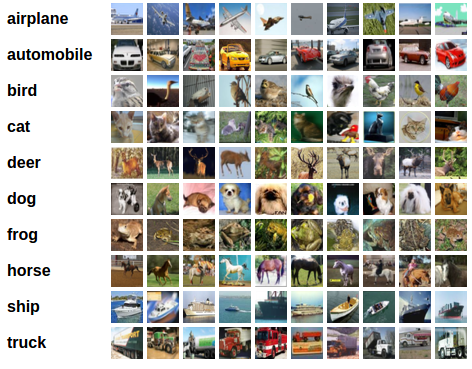

## Training an image classifier
We will do the following steps in order:
- Load and normalize the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

## 1. Load and normalize CIFAR10
Using torchvision, it's extremely easy to load CIFAR10.

In [93]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [94]:
# transforms.ToTensor()：将 PIL.Image 图像转化为 PyTorch 张量，并将每个像素值从 [0,255] 压缩到 [0,1] 的范围内
# 将图像数据转换为张量，并对图像数据进行归一化处理
# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))：对每个张量进行归一化处理，即将每个像素的值减去均值 (0.5, 0.5, 0.5)，
# 再除以标准差 (0.5, 0.5, 0.5)，使得像素值分布在 [-1,1] 的范围内
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
trainloader可以将 trainset 中的数据进行打乱、分组、并行读取等操作，并将其组织成经过预处理和批量处理的数据集合。
trainloader对象可以很方便地被用来迭代训练集中的数据,每次迭代可以将一个或多个批次的数据送入深度学习模型进行训练
num_workers表示在数据加载器中用于加载数据的子进程数量，即用来处理数据的 CPU 核心数
'''

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

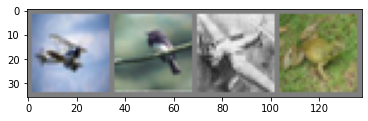

plane bird  plane frog 


In [95]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
# torchvision.utils.make_grid其实就是将多张图片组合成一张图片
imshow(torchvision.utils.make_grid(images))
# print labels
# f让后面大括号里的都是字符串，classes就是所有的标签，冒号默认左对齐，5s表示占用5个字符的宽度
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Define a Convolutional Neural Network


In [96]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

## 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [97]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [98]:
losses_list = []
accuracy_list = []
def checkAccuracy():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy_list.append(correct / total)
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            losses_list.append(running_loss / 2000)
            running_loss = 0.0
            checkAccuracy()

print('Finished Training')

[1,  2000] loss: 2.228
Accuracy of the network on the 10000 test images: 24 %
[1,  4000] loss: 1.924
Accuracy of the network on the 10000 test images: 33 %
[1,  6000] loss: 1.740
Accuracy of the network on the 10000 test images: 40 %
[1,  8000] loss: 1.609
Accuracy of the network on the 10000 test images: 42 %
[1, 10000] loss: 1.539
Accuracy of the network on the 10000 test images: 47 %
[1, 12000] loss: 1.485
Accuracy of the network on the 10000 test images: 47 %
[2,  2000] loss: 1.447
Accuracy of the network on the 10000 test images: 48 %
[2,  4000] loss: 1.373
Accuracy of the network on the 10000 test images: 50 %
[2,  6000] loss: 1.367
Accuracy of the network on the 10000 test images: 52 %
[2,  8000] loss: 1.345
Accuracy of the network on the 10000 test images: 52 %
[2, 10000] loss: 1.319
Accuracy of the network on the 10000 test images: 54 %
[2, 12000] loss: 1.302
Accuracy of the network on the 10000 test images: 53 %
[3,  2000] loss: 1.231
Accuracy of the network on the 10000 test

Let’s quickly save our trained model:

In [99]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

60
60


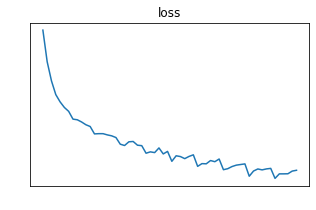

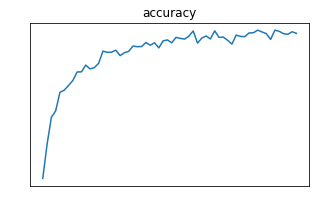

In [104]:

print(len(accuracy_list))
print(len(losses_list))

plt.figure(figsize=(5,3))
plt.plot(np.arange(0,len(losses_list)), losses_list)
plt.title('loss')
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')


plt.figure(figsize=(5,3))
plt.plot(np.arange(0,len(accuracy_list)), accuracy_list)
plt.title('accuracy')
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')

In [105]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

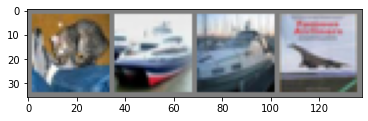

GroundTruth:  cat   ship  ship  plane


In [80]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [81]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [83]:
'''
这里报错是因为加载net的时候按gpu加载了,要是想看结果就把上一个cell的to(device)注释掉
但是运行下面的时候记得再加载一下net,要用gpu加载
'''
outputs = net(images))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [84]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  bird  cat   ship  truck


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [85]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [86]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 73.3 %
Accuracy for class: car   is 75.3 %
Accuracy for class: bird  is 57.8 %
Accuracy for class: cat   is 43.5 %
Accuracy for class: deer  is 56.2 %
Accuracy for class: dog   is 45.7 %
Accuracy for class: frog  is 75.9 %
Accuracy for class: horse is 64.1 %
Accuracy for class: ship  is 71.7 %
Accuracy for class: truck is 68.8 %
